# Procesy Stochastyczne

In [132]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import firwin, lfilter

In [133]:
# Set Random seed
np.random.seed(69420)

In [134]:
# Parametry
# Parametr sigma rozkładu Rayleigha
sigma = 1.0
# Częstotliwość próbkowania w Hz
sampling_freq = 10000
# Liczba różnych próbek
sample_sizes = [1000, 5000, 10000, 50000]

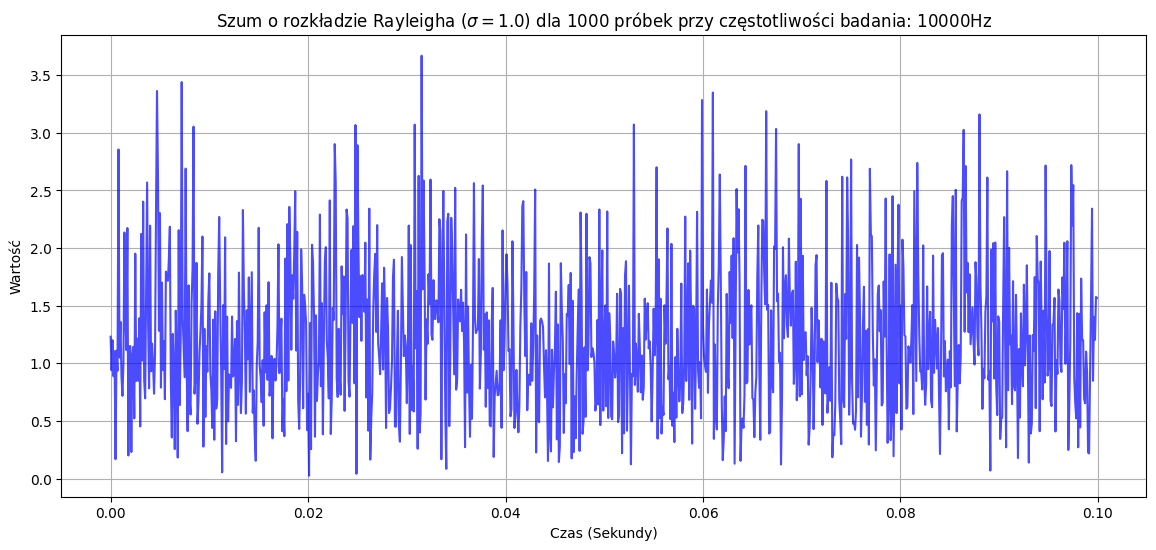

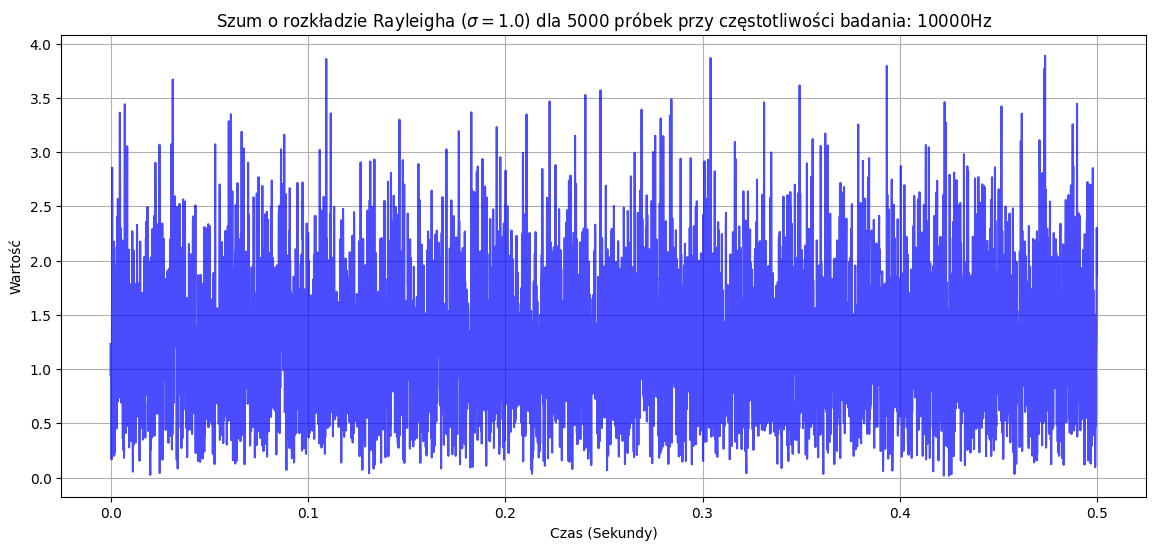

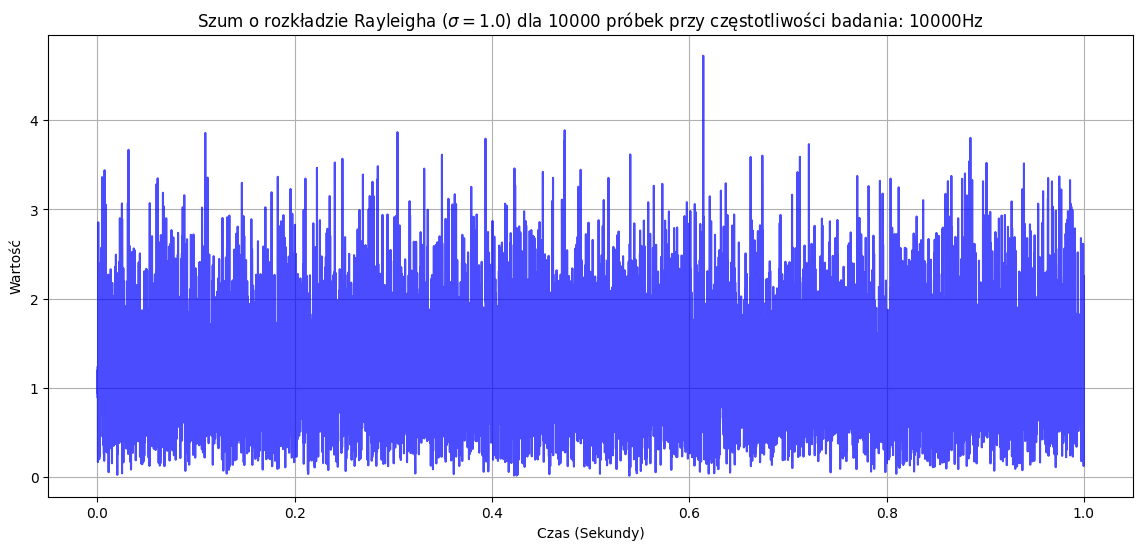

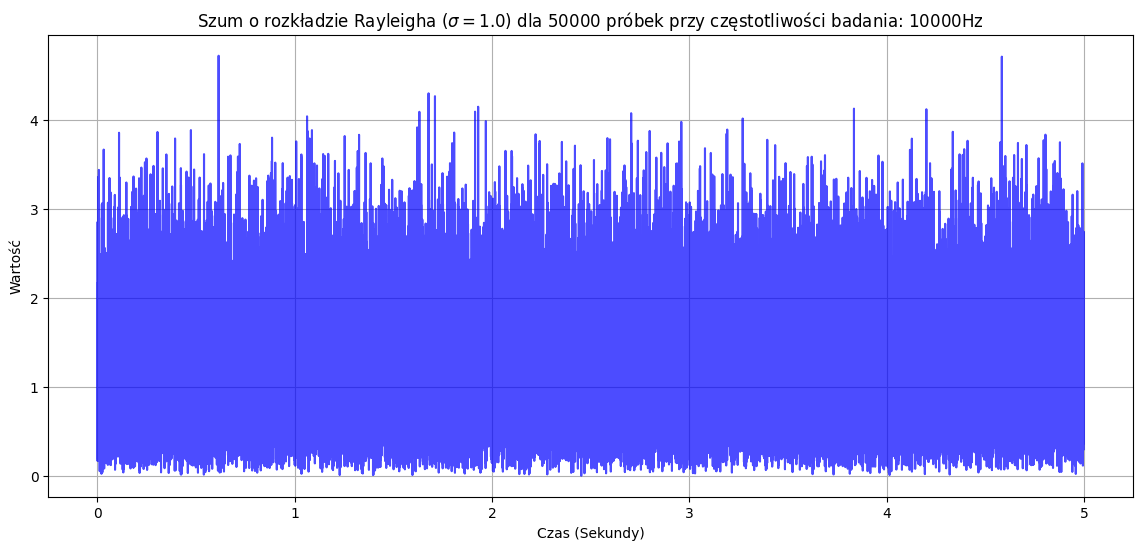

In [135]:
# Obliczenie dodatkowych parametrow
# Liczba wszystkich próbek
num_samples = max(sample_sizes)
# Całkowita długośćtrwania sygnału
duration = num_samples/sampling_freq

# Generowanie szumu
rayleigh_noise = np.random.rayleigh(scale=sigma, size=num_samples)

# Wizualizacja szumu przy różnej ilości próbek
for samples in sample_sizes:
    x_time = np.array([x/num_samples * duration for x in range(samples)])
    plt.figure(figsize=(14, 6))
    plt.plot(x_time, rayleigh_noise[:samples], color="blue", alpha=0.7)
    plt.title(f"Szum o rozkładzie Rayleigha ($\\sigma=1.0$) dla {samples} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Czas (Sekundy)", )
    plt.ylabel("Wartość")
    plt.grid(True)
    plt.show()

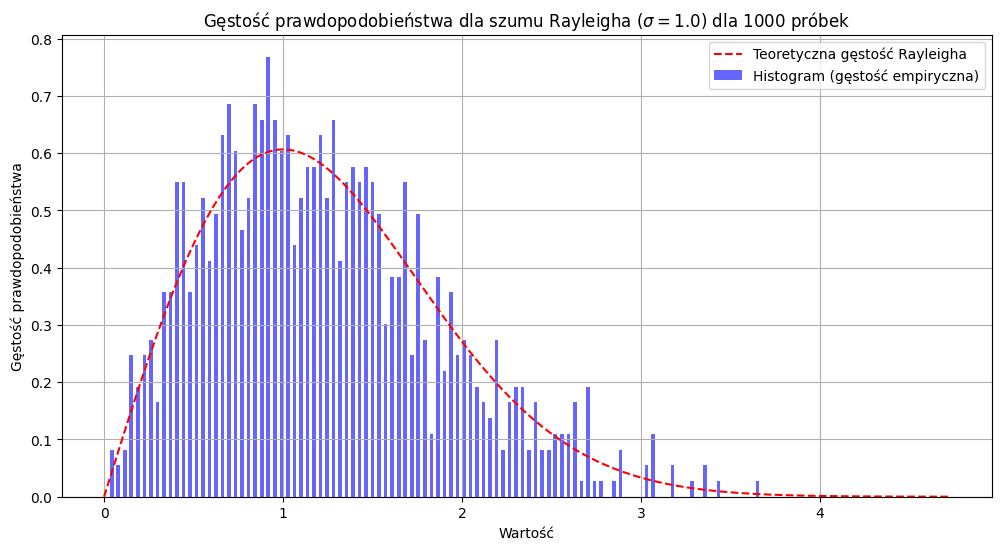

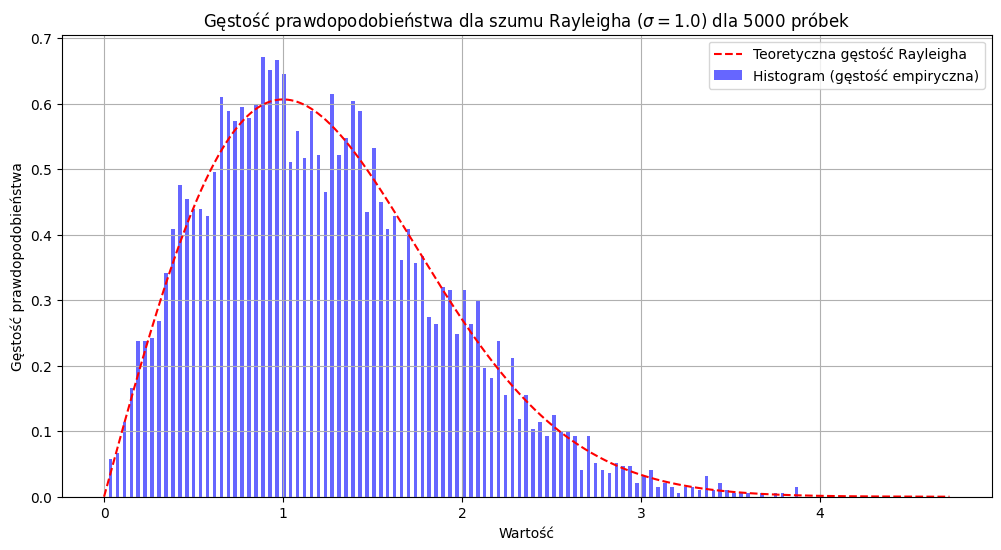

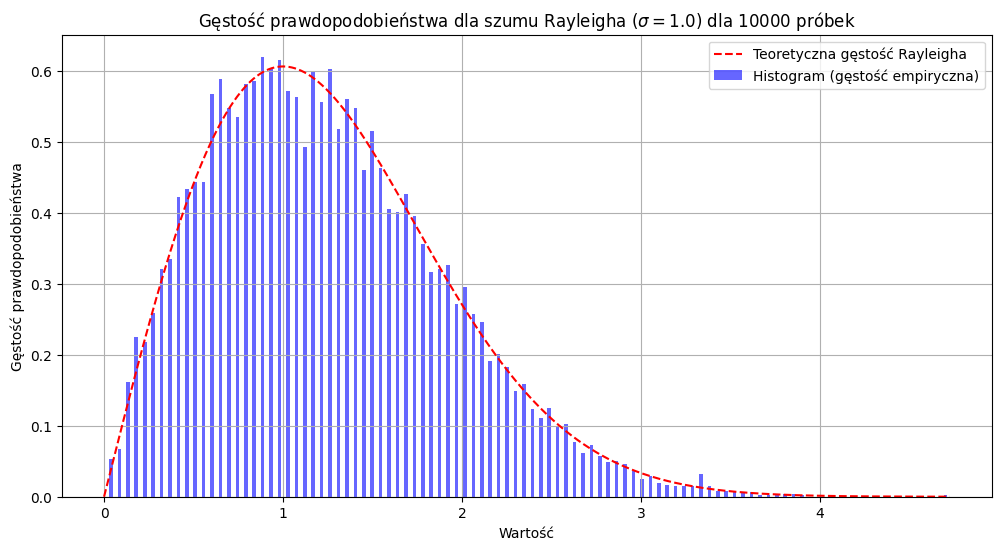

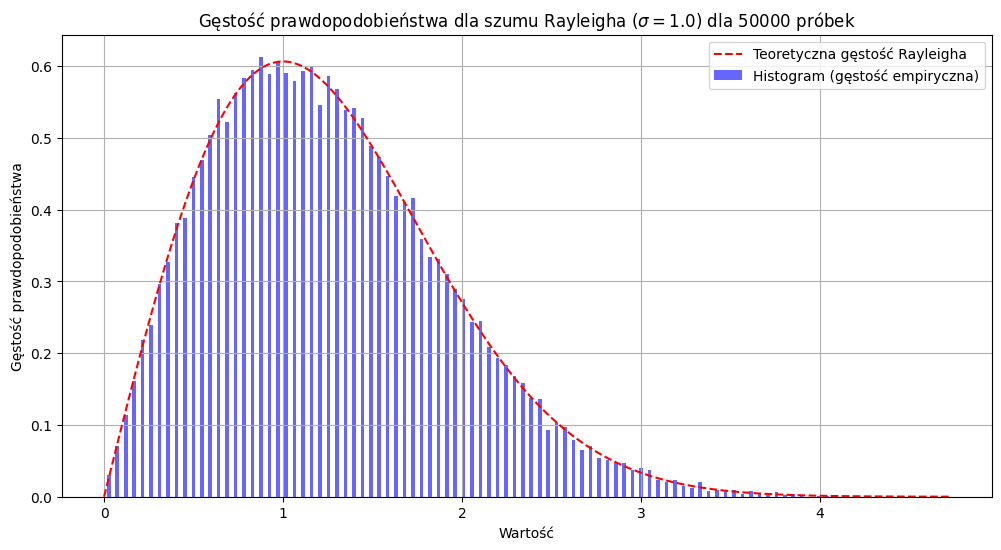

In [151]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla wygenerowanego szumu
pdf_values = []
bins = []
bin_centers = []

x = []
rayleigh_pdf = []

for i in range(len(sample_sizes)):
    pdf_values_d, bins_d = np.histogram(rayleigh_noise[:sample_sizes[i]], bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    pdf_values.append(pdf_values_d)
    bins.append(bins_d)
    bin_centers.append(bin_centers_d)

    # Wzorcowa funkcja gęstości prawdopodobieństwa rozkładu Rayleigha dla porównania
    x.append(np.linspace(0, max(rayleigh_noise), sample_sizes[i]))
    rayleigh_pdf.append(stats.rayleigh.pdf(x[i], scale=sigma))

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[i], rayleigh_pdf[i], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]} próbek")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

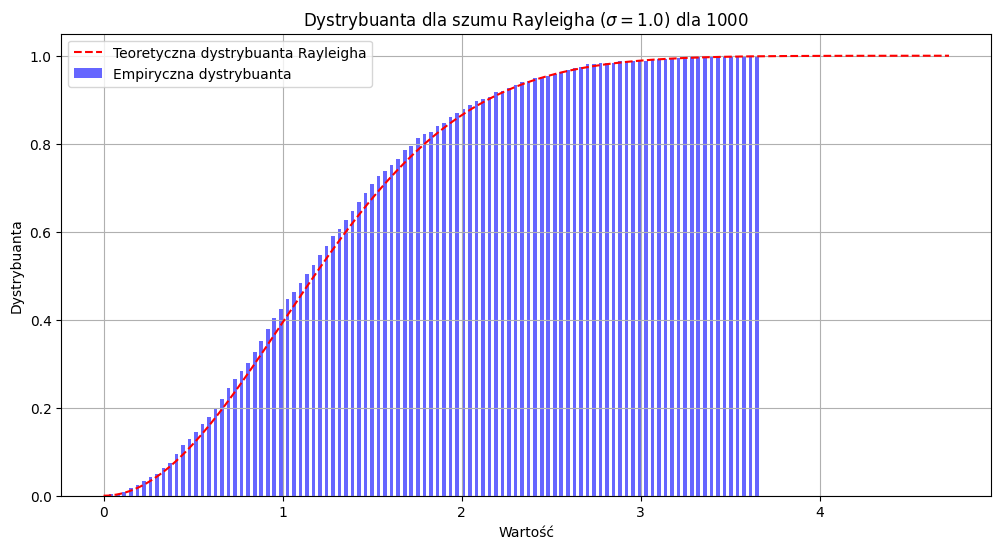

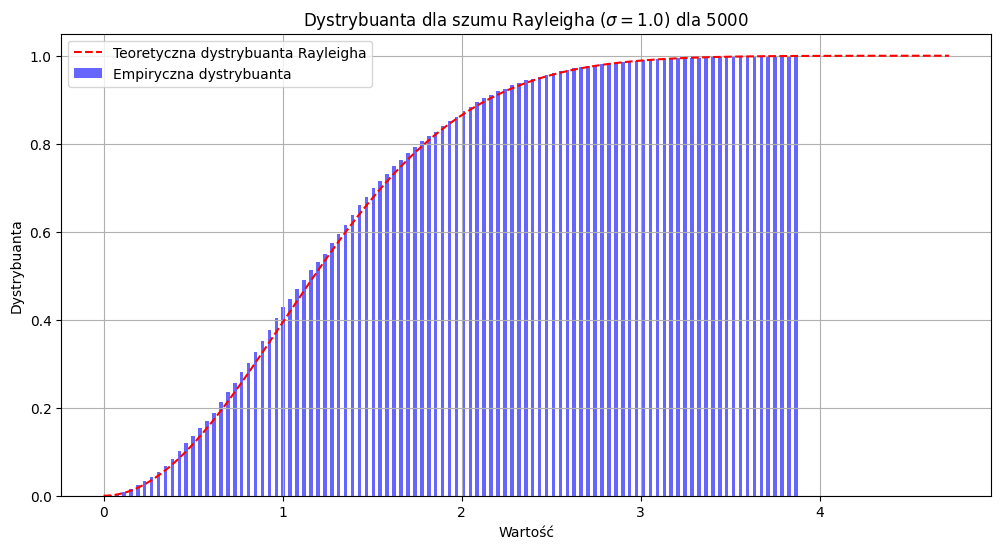

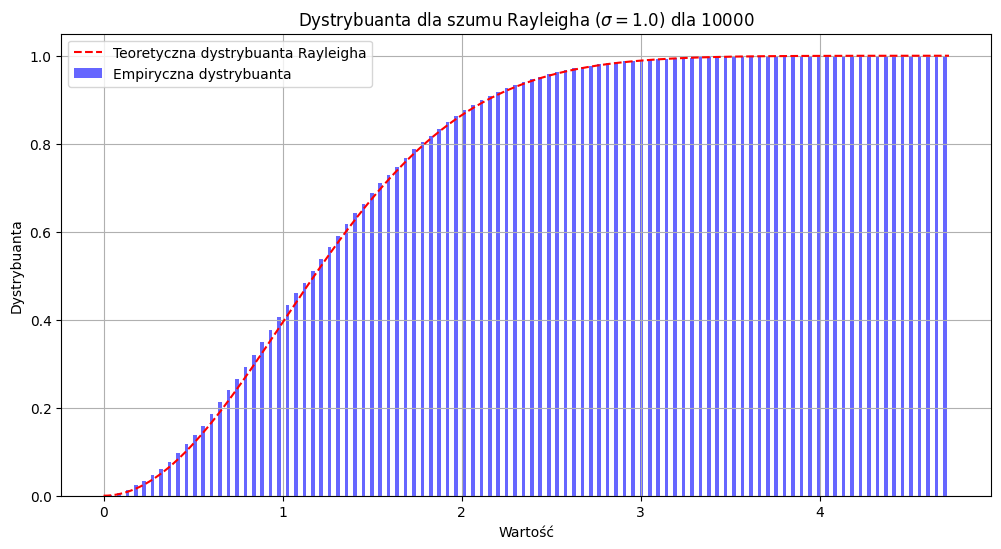

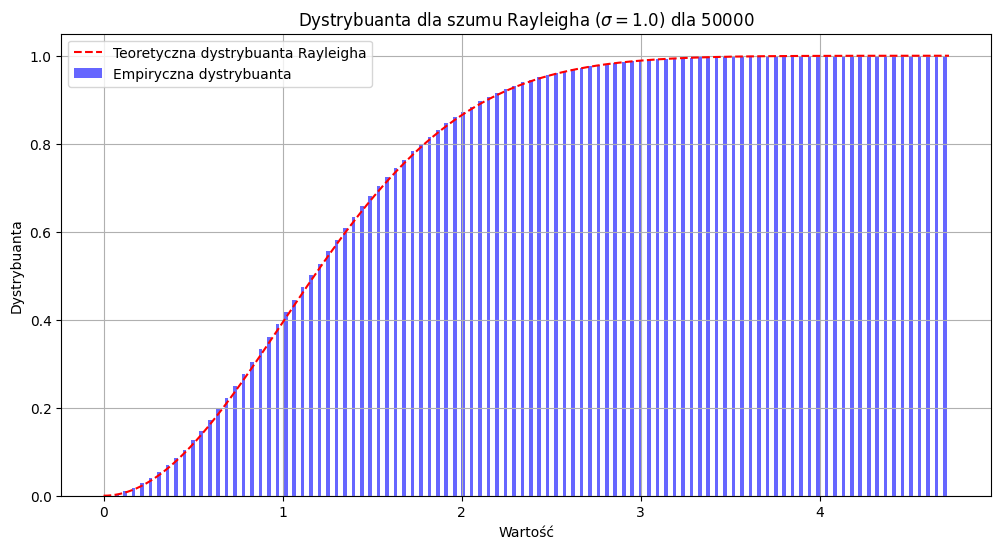

In [150]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
rayleigh_cdf_empirical = []

for i in range(len(sample_sizes)):
    rayleigh_cdf_empirical.append(np.cumsum(pdf_values[i] * np.diff(bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[i], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(bin_centers[i], rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[i], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla szumu Rayleigha ($\\sigma=1.0$) dla {sample_sizes[i]}")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [138]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
summary_table = pd.DataFrame(sample_sizes, columns=['Sample Size'])
summary_table.set_index('Sample Size', inplace = True)
summary_table['Mean/Expected Value'] = 0.0
summary_table['Wariant'] = 0.0
summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for sample_size in sample_sizes:
    table = pd.DataFrame(rayleigh_noise[:sample_size], columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    summary_table.at[sample_size, 'Mean/Expected Value'] = rayleigh_noise[:sample_size].mean()

    table['x - xsr'] = table['x'] - summary_table.at[sample_size, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    summary_table.at[sample_size, 'Wariant'] = (table['(x - xsr)^2'].sum())/(sample_size-1)
    
    statistic_tables.append(table)

summary_table['Standard Deviation'] = summary_table['Wariant']**(1/2)

# Podsumowanie
summary_table

,Mean/Expected Value,Wariant,Standard Deviation
Sample Size,,,
1000,1.224375,0.425301,0.652151
5000,1.236764,0.430649,0.656238
10000,1.244796,0.433730,0.658582
50000,1.255218,0.429222,0.655151


In [140]:
# Obliczenie funkcji kowariancji
# Sumy kowariancji dla poszczególnej liczby próbek:
kowariance_sums = []

# Obliczenie Poszczególnych wyników - Bardzo powolne - niezoptymalizowane.
j_lag = 100
for table in statistic_tables:
    samples = len(table)
    kov_sums_sample = []
    # Stworzenie pustej tabeli
    j_table = pd.DataFrame([[0.0 for i in range(j_lag+1)]for j in range(samples)],
                    columns = [f'f{k}' for k in range(1, j_lag+2)])
    table = table.join(j_table)
    for j in range(j_lag):
        print(f"Table - {samples}: j: {j} / {j_lag}     ", end = '\r')
        samples_n_cov = samples - j
        for i, row in table.iterrows():
            if i >= samples_n_cov:
                break
            table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]
        kov_sums_sample.append(table[f"j{j}"].sum() / samples_n_cov)
    kowariance_sums.append(kov_sums_sample)
    print()         

C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


C:\Users\slawe\AppData\Local\Temp\ipykernel_10276\1071842145.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[i, f"j{j}"] = table["x - xsr"][i] * table["x - xsr"][i+j]


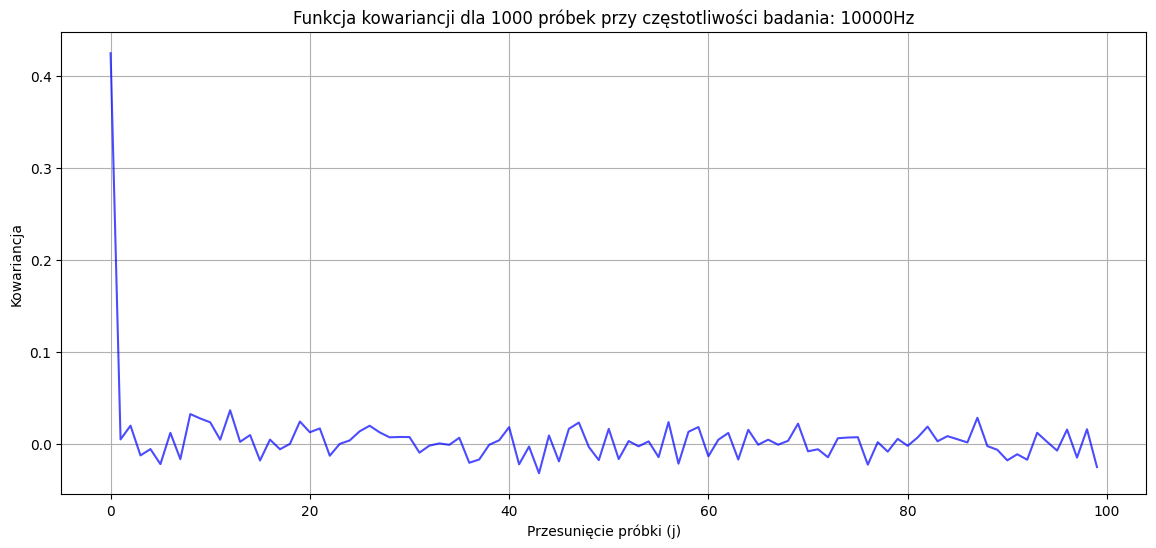

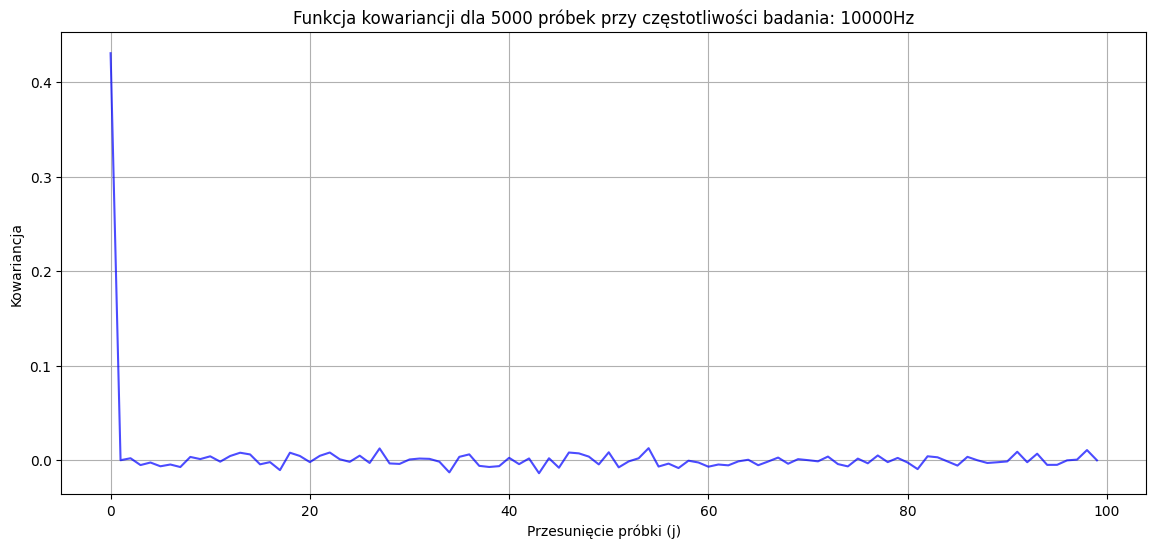

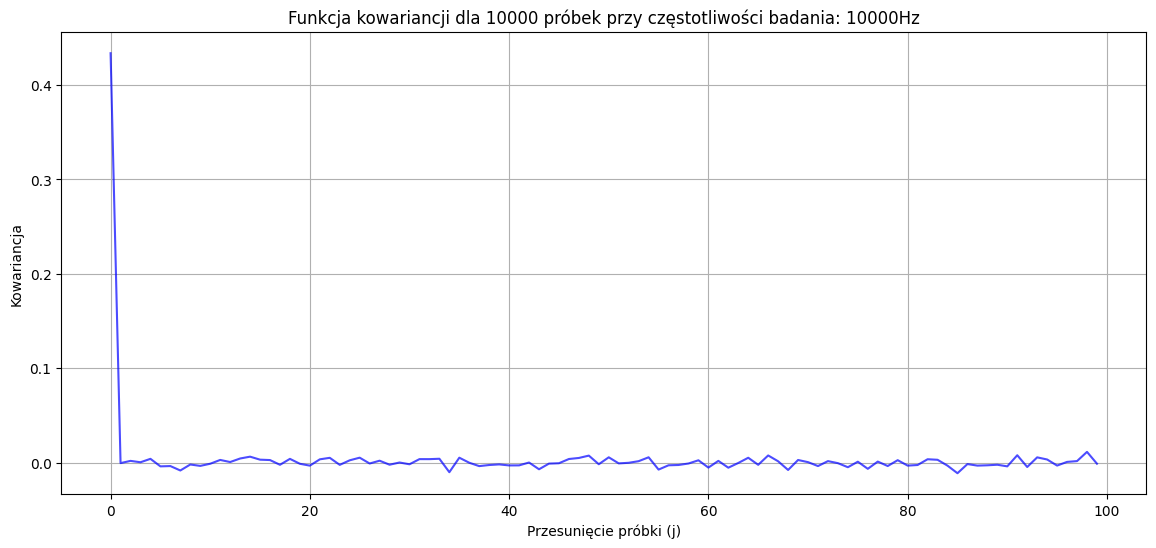

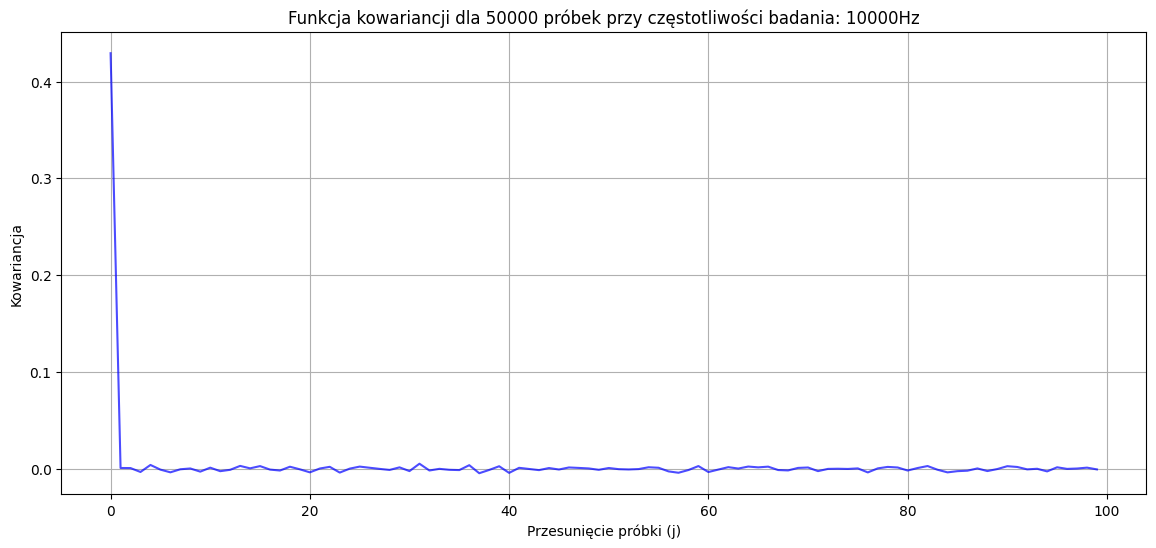

In [141]:
# Rysowanie Funkcji Kowariancji
kowariance_sums_table = pd.DataFrame(kowariance_sums)
kowariance_sums_table = kowariance_sums_table.transpose()

for col in kowariance_sums_table.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(kowariance_sums_table[col], color="blue", alpha=0.7)
    plt.title(f"Funkcja kowariancji dla {sample_sizes[col]} próbek przy częstotliwości badania: {sampling_freq}Hz")
    plt.xlabel("Przesunięcie próbki (j)", )
    plt.ylabel("Kowariancja")
    plt.grid(True)
    plt.show()

In [142]:
# Filtracja Szumu
# Funkcja do projektowania i stosowania filtru FIR
def apply_fir_filter(noise, cutoff_freq, tap_count, fs):
    taps = firwin(tap_count, cutoff_freq, fs=fs, pass_zero="lowpass")
    filtered_signal = lfilter(taps, 1.0, noise)
    return filtered_signal, taps

# Definicje różnych szerokości filtru
filters = [
    {"cutoff_freq": 500, "tap_count": 51},
    {"cutoff_freq": 1000, "tap_count": 101},
    {"cutoff_freq": 2000, "tap_count": 201}
]

# Filtracja sygnału z różnymi filtrami
filtered_signals = []
for filt in filters:
    filtered_signal, taps = apply_fir_filter(rayleigh_noise, filt["cutoff_freq"], filt["tap_count"], num_samples)
    filtered_signals.append(filtered_signal)

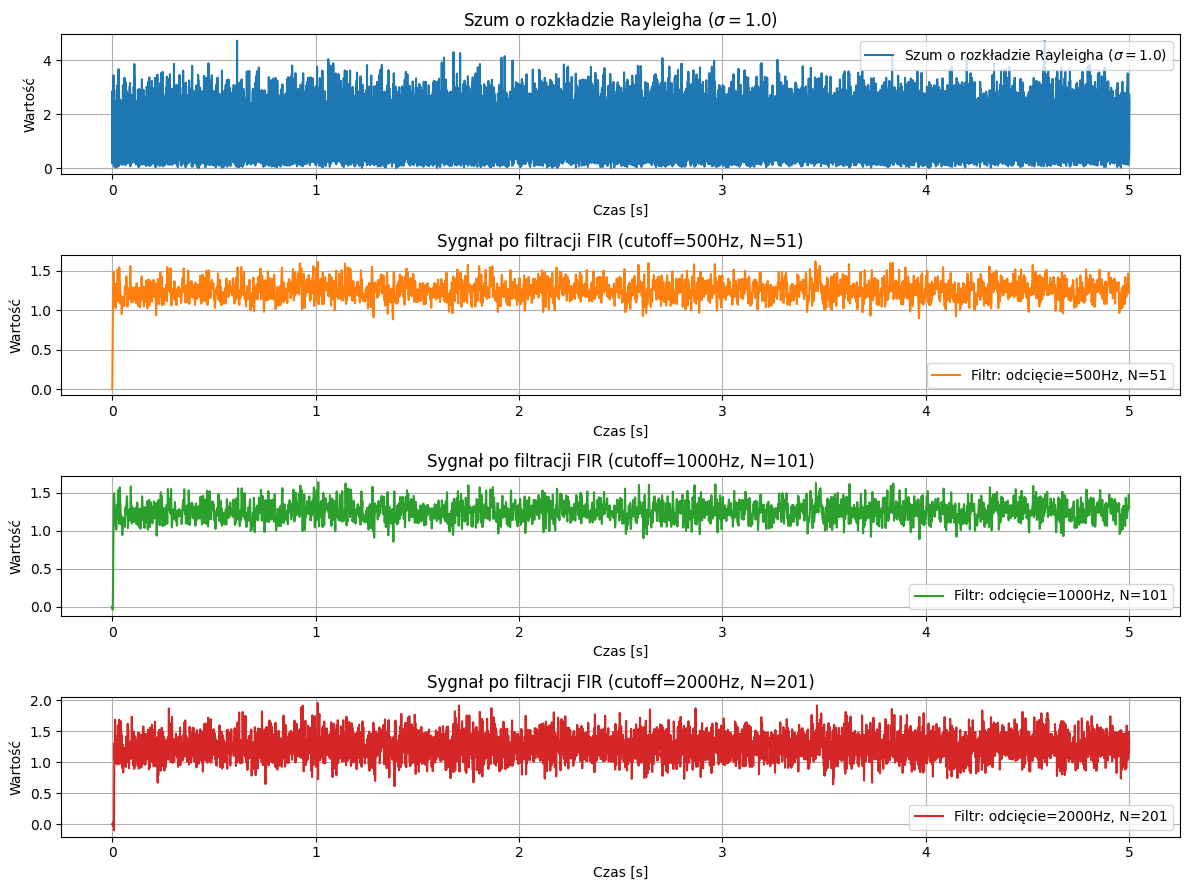

In [152]:
# Wizualizacja
plt.figure(figsize=(12, 9))

# Biały szum
plt.subplot(len(filters) + 1, 1, 1)
plt.plot(x_time, rayleigh_noise, label="Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.title("Szum o rozkładzie Rayleigha ($\\sigma=1.0$)")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.grid()
plt.legend()

# Sygnały po filtracji z różnymi szerokościami filtru
for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters) + 1, 1, i + 2)
    plt.plot(x_time, filtered_signal, 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}",
             color=f"C{i+1}")
    plt.title(f"Sygnał po filtracji FIR (cutoff={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

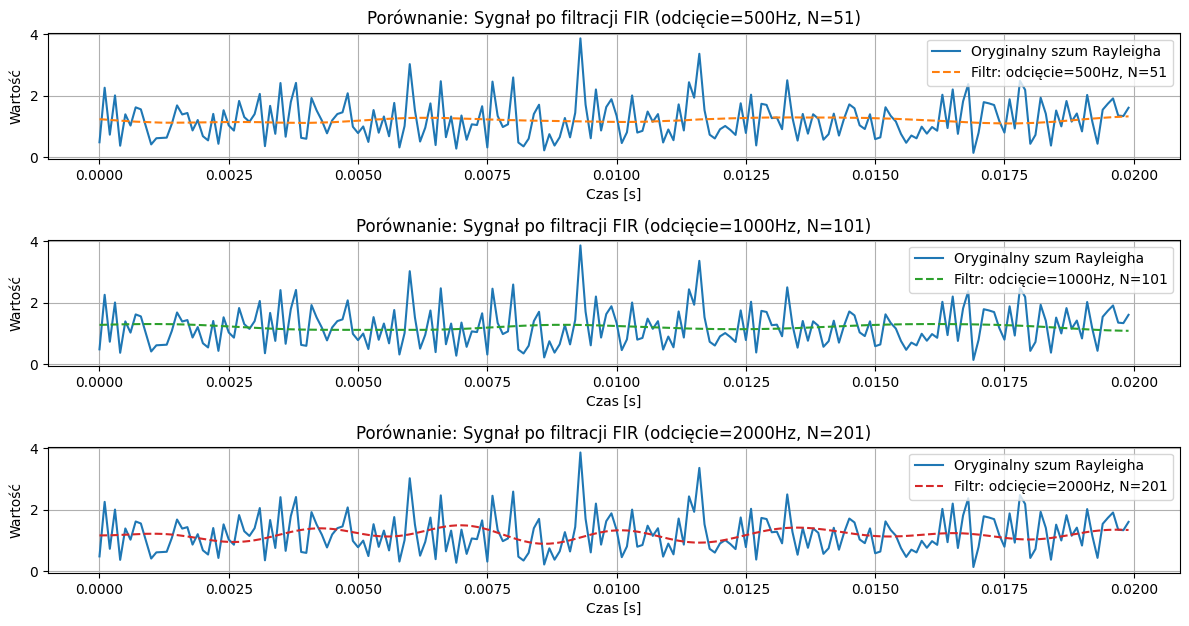

In [144]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 200
start_sample = 1000
end_sample = start_sample + compare_samples

plt.figure(figsize=(12, 8))

for i, (filtered_signal) in enumerate(filtered_signals):
    plt.subplot(len(filters)+1, 1, i + 1)
    plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
    plt.plot(x_time[:compare_samples], 
             filtered_signal[start_sample:end_sample], 
             label=f"Filtr: odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}", 
             color=f"C{i+1}",  
             linestyle='dashed'
             )
    plt.title(f"Porównanie: Sygnał po filtracji FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Czas [s]")
    plt.ylabel("Wartość")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

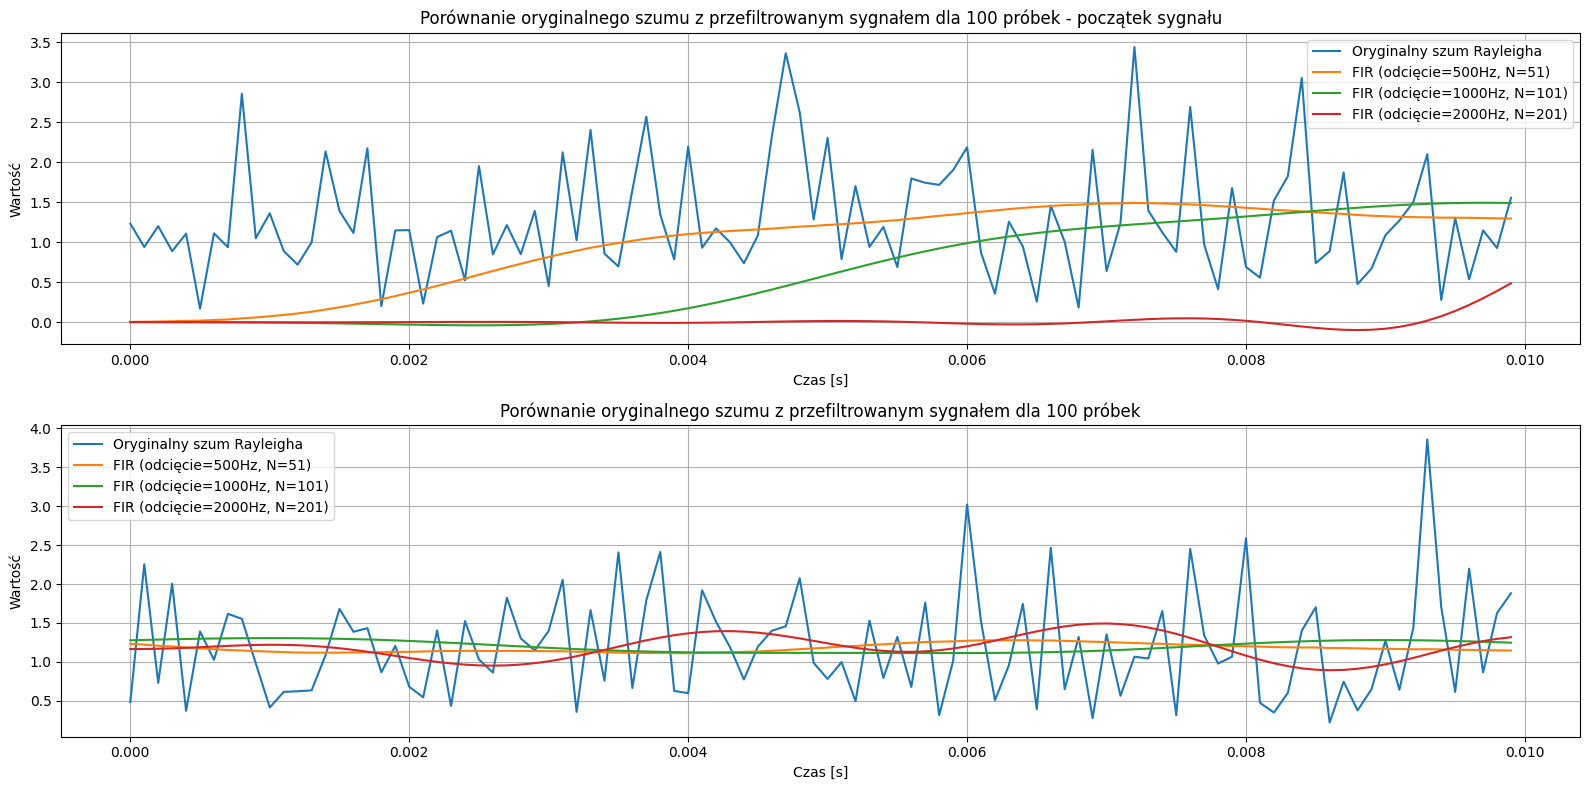

In [145]:
# Wizualizacja - Porownanie z Oryginalem - waski przedział
compare_samples = 100
start_sample = 1000
end_sample = start_sample + compare_samples


plt.figure(figsize=(16, 8))

# Sygnał pierwotny
plt.subplot(2, 1, 1)
plt.plot(x_time[:compare_samples], rayleigh_noise[:compare_samples], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][:compare_samples],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek - początek sygnału")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

# Sygnał przefiltrowany
plt.subplot(2, 1, 2)
plt.plot(x_time[:compare_samples], rayleigh_noise[start_sample:end_sample], label="Oryginalny szum Rayleigha")
for i, filtered_signal in enumerate(filtered_signals):
    plt.plot(x_time[:compare_samples], filtered_signals[i][start_sample:end_sample],
             color=F'C{i+1}',
             label=f"FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
plt.title(f"Porównanie oryginalnego szumu z przefiltrowanym sygnałem dla {compare_samples} próbek")
plt.xlabel("Czas [s]")
plt.ylabel("Wartość")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

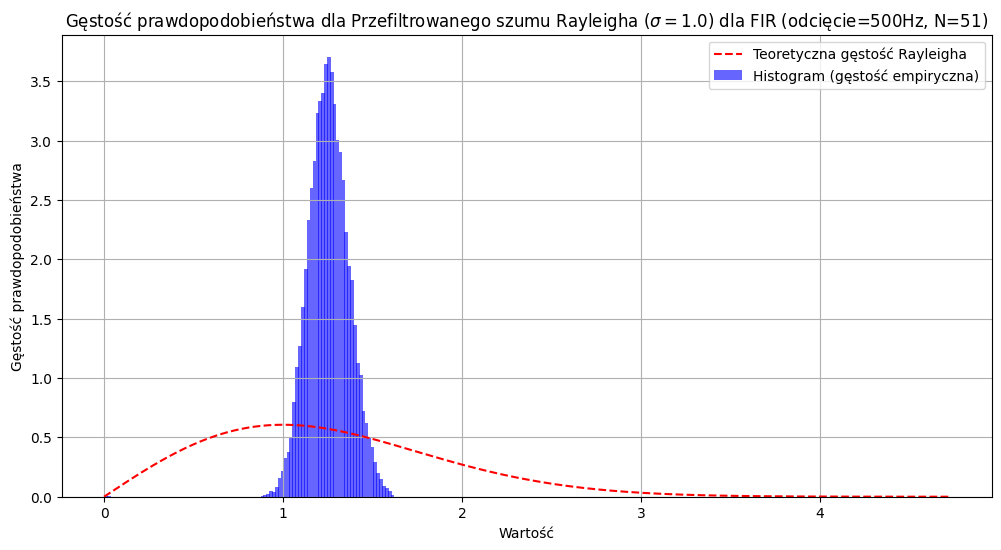

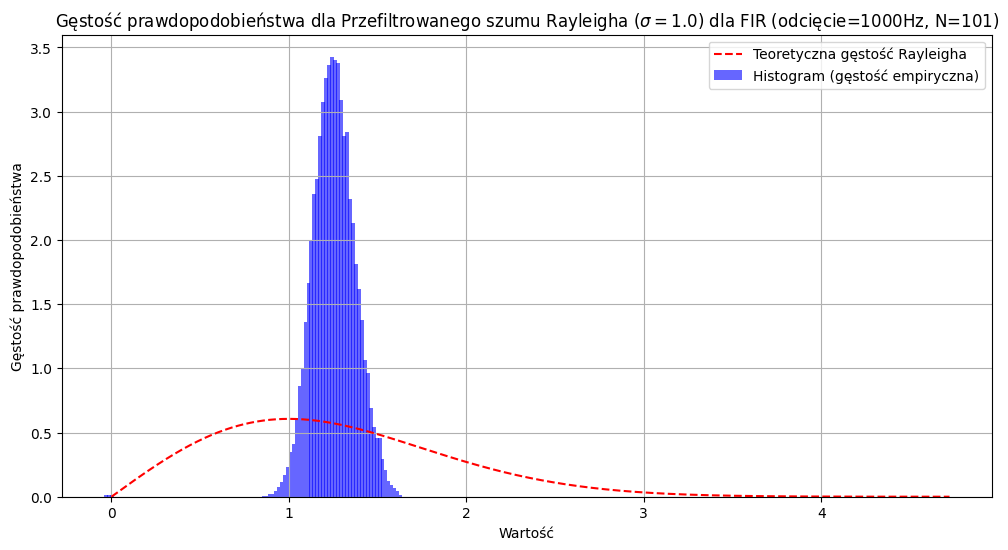

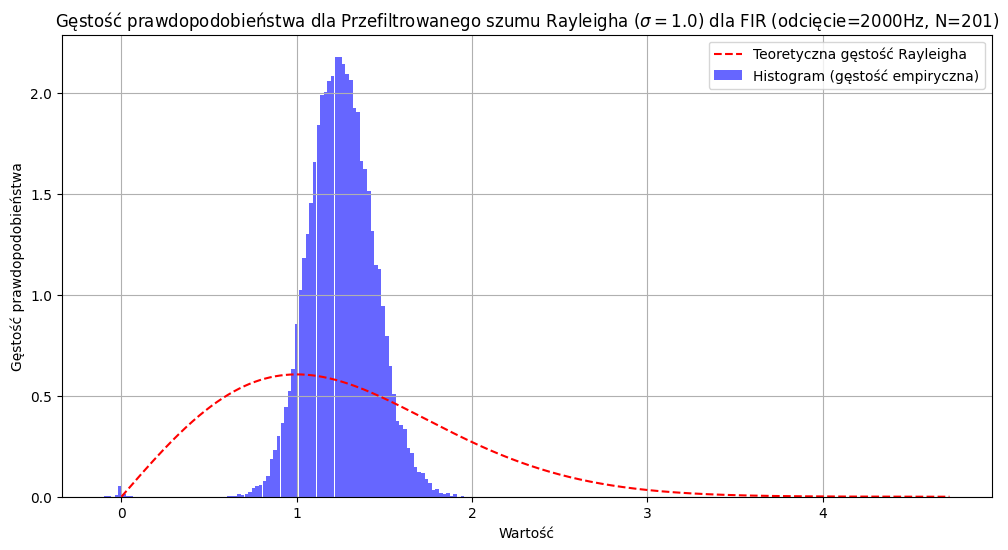

In [147]:
# Wyznaczenie gęstości prawdopodobieństwa (PDF) dla przefiltrowanego szumu
filtered_pdf_values = []
filtered_bins = []
filtered_bin_centers = []

for i, filtered_signal in enumerate(filtered_signals):
    pdf_values_d, bins_d = np.histogram(filtered_signal, bins=100, density=True)
    bin_centers_d = (bins_d[:-1] + bins_d[1:]) / 2  # Środkowe wartości przedziałów
    filtered_pdf_values.append(pdf_values_d)
    filtered_bins.append(bins_d)
    filtered_bin_centers.append(bin_centers_d)

    # Rysowanie histogramu i PDF
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_pdf_values[i], label="Histogram (gęstość empiryczna)", color="blue", width=0.02, alpha=0.6, )
    plt.plot(x[-1], rayleigh_pdf[-1], label="Teoretyczna gęstość Rayleigha", color="red", linestyle="--")
    plt.title(f"Gęstość prawdopodobieństwa dla Przefiltrowanego szumu Rayleigha ($\\sigma=1.0$) dla FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość prawdopodobieństwa")
    plt.legend()
    plt.grid(True)
    plt.show()

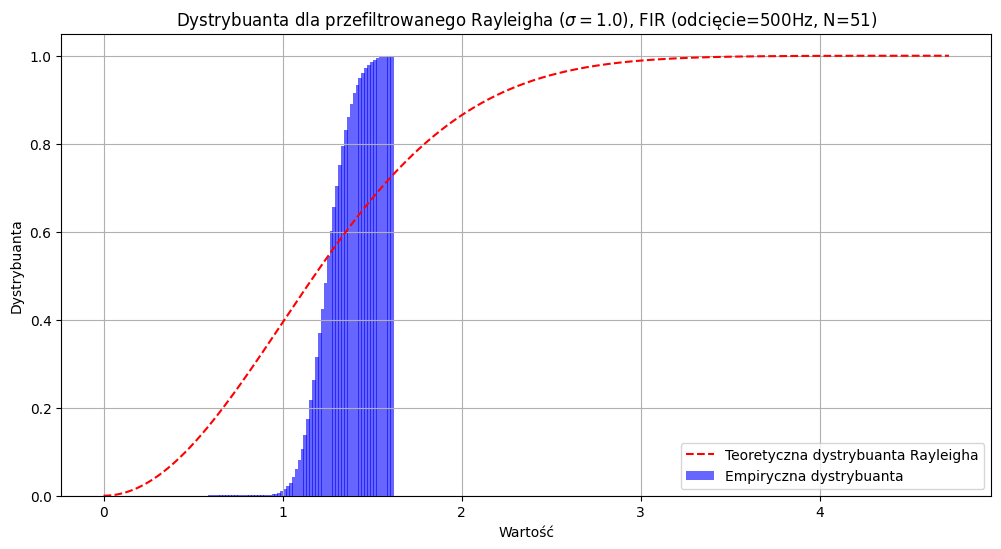

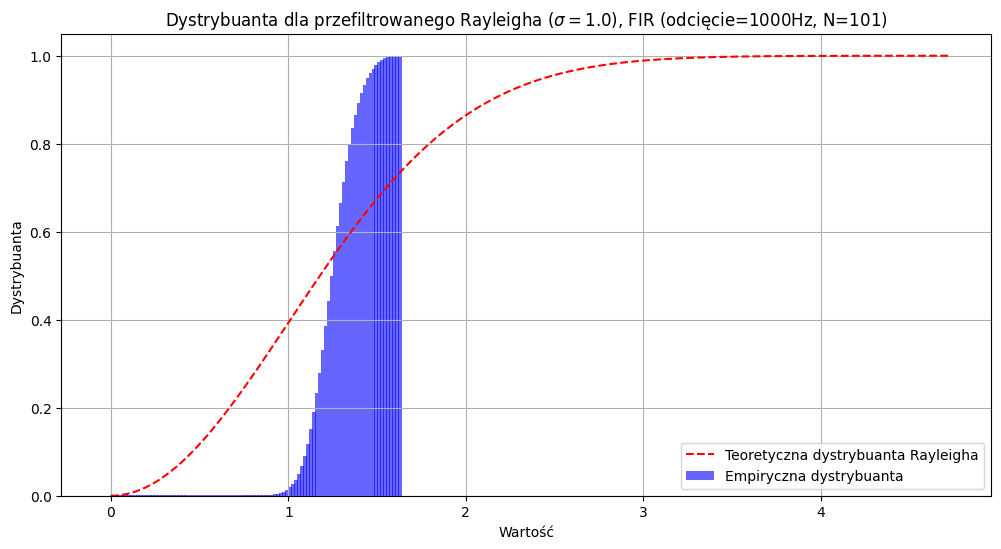

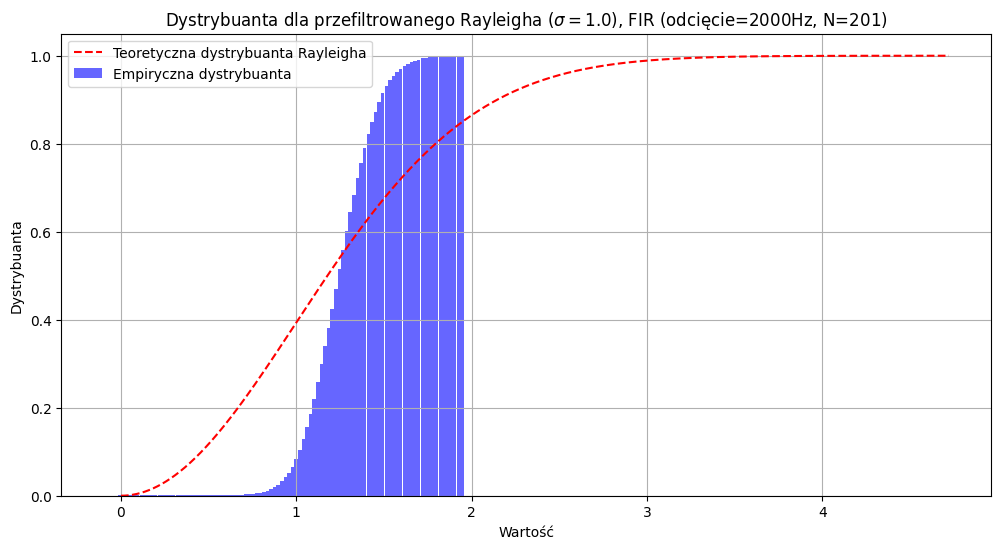

In [148]:
# Obliczanie dystrybuanty (CDF) dla rozkładu Rayleigha na podstawie wygenerowanego szumu
filtered_rayleigh_cdf_empirical = []

for i, filtered_signal in enumerate(filtered_signals):
    filtered_rayleigh_cdf_empirical.append(np.cumsum(filtered_pdf_values[i] * np.diff(filtered_bins[i])))  # Numeryczna aproksymacja CDF z histogramu

    # Teoretyczna dystrybuanta rozkładu Rayleigha
    rayleigh_cdf_theoretical = stats.rayleigh.cdf(x[-1], scale=sigma)

    # Rysowanie dystrybuanty
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_bin_centers[i], filtered_rayleigh_cdf_empirical[i], label="Empiryczna dystrybuanta", color="blue", width=0.02, alpha=0.6)
    plt.plot(x[-1], rayleigh_cdf_theoretical, label="Teoretyczna dystrybuanta Rayleigha", color="red", linestyle="--")
    plt.title(f"Dystrybuanta dla przefiltrowanego Rayleigha ($\\sigma=1.0$), FIR (odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']})")
    plt.xlabel("Wartość")
    plt.ylabel("Dystrybuanta")
    plt.legend()
    plt.grid(True)
    plt.show()

In [149]:
# Obliczenie Wartości Oczekiwanej, Wariancji
# Tabele do obliczeń statystycznych
filtered_statistic_tables: list[pd.DataFrame] = []
# Tabela Wyników
used_filters = [
    f"FIR odcięcie={filters[i]['cutoff_freq']}Hz, N={filters[i]['tap_count']}" for i in range(len(filtered_signals))
]
filtered_summary_table = pd.DataFrame(used_filters, columns=['Filter'])
filtered_summary_table['Mean/Expected Value'] = 0.0
filtered_summary_table['Wariant'] = 0.0
filtered_summary_table['Standard Deviation'] = 0.0

# Obliczenie parametrów
for i, filtered_signal in enumerate(filtered_signals):
    table = pd.DataFrame(filtered_signal, columns = ['x'])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    filtered_summary_table.at[i, 'Mean/Expected Value'] = filtered_signal.mean()

    table['x - xsr'] = table['x'] - filtered_summary_table.at[i, 'Mean/Expected Value']
    table['(x - xsr)^2'] = table['x - xsr']**2

    filtered_summary_table.at[i, 'Wariant'] = (table['(x - xsr)^2'].sum())/(num_samples-1)
    
    filtered_statistic_tables.append(table)

filtered_summary_table['Standard Deviation'] = filtered_summary_table['Wariant']**(1/2)

# Podsumowanie
filtered_summary_table

,Filter,Mean/Expected Value,Wariant,Standard Deviation
0,"FIR odcięcie=500Hz, N=51",1.254526,0.012880,0.113489
1,"FIR odcięcie=1000Hz, N=101",1.253901,0.015092,0.122849
2,"FIR odcięcie=2000Hz, N=201",1.252505,0.035602,0.188685


In [76]:
df = pd.DataFrame(['1', '2', '3'], columns = ['x'])

rows = 3
columns = 10

df2 = pd.DataFrame([[0 for i in range(columns)]for j in range(rows)],
                    columns = [f'f{k}' for k in range(columns)])

df = df.join(df2)


3